In [8]:
from pathlib import Path

import matplotlib.colors as mcolors  # For LogNorm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import torch
from tqdm import tqdm

sns.set_theme(style="whitegrid")

DEVICE = torch.device("cuda:0")

# Plotting functions

In [2]:
def poisson_cdf(x, rate):
    """
    Compute CDF of Poisson(rate) at value x
    x: integer or tensor of integers
    rate: Poisson rate (mean λ), can be broadcastable
    """
    x = torch.floor(x).to(torch.int64)
    max_k = x.max().item()
    ks = torch.arange(0, max_k + 1, device=DEVICE).view(1, -1)

    # Broadcast rate to match ks shape
    rate = rate.view(-1, 1)

    # Compute PMF values up to x
    log_pmf = ks * torch.log(rate) - rate - torch.lgamma(ks + 1)
    pmf = torch.exp(log_pmf)

    # Cumulative sum and gather the value at position x
    cdf_table = torch.cumsum(pmf, dim=1)

    # Gather corresponding CDF value for each x
    result = cdf_table[torch.arange(len(x)), x]
    return result


# def nb_cdf(x, mu, r):
#     """
#     Compute CDF of Negative Binomial(mu, phi) at value x
#     x: integer or tensor of integers
#     mu: mean of the distribution
#     r: count parameter
#     """
#     logits = torch.log(mu / r)
#     nb = dist.NegativeBinomial(total_count=r, logits=logits)

#     return nb.cdf(x)

def nb_cdf(x, mu, r):
    """
    Compute CDF of NegativeBinomial(mu, r) at value x.
    The distribution is parameterized by mean 'mu' and 'r' (number of failures).
    P(X=k) = C(k+r-1, k) * p^r * (1-p)^k, where p = r / (mu+r).
    X is the number of successes given r failures.

    x: integer value(s) to evaluate CDF at (can be scalar or tensor).
    mu: mean of the Negative Binomial distribution (mu > 0). Can be scalar or tensor.
    r: number of failures (dispersion parameter, r > 0). Can be scalar or tensor.
    """
    # Ensure inputs are tensors and determine their data type and device
    # We'll use float for calculations and then convert x to int for indexing.
    if not isinstance(x, torch.Tensor):
        # Try to infer dtype and device from mu or r if they are tensors
        if isinstance(mu, torch.Tensor):
            dtype = mu.dtype
        elif isinstance(r, torch.Tensor):
            dtype = r.dtype
        else: # All scalars
            dtype = torch.float32
        x = torch.as_tensor(x, dtype=dtype, device=DEVICE)
    else:
        dtype = x.dtype

    mu = torch.as_tensor(mu, dtype=dtype, device=DEVICE)
    r = torch.as_tensor(r, dtype=dtype, device=DEVICE)

    # --- Input Validation ---
    if torch.any(mu < 0):
        raise ValueError("mu (mean) must be non-negative.")
    if torch.any(r <= 0):
        raise ValueError("r (number of failures) must be positive.")

    # --- Broadcasting ---
    # Determine common broadcast shape for x, mu, r
    try:
        common_shape = torch.broadcast_shapes(x.shape, mu.shape, r.shape)
    except RuntimeError:
        raise ValueError(f"x, mu, r shapes ({x.shape}, {mu.shape}, {r.shape}) are not broadcastable.")

    # Broadcast all inputs to the common shape
    x_b = x.broadcast_to(common_shape)
    mu_b = mu.broadcast_to(common_shape)
    r_b = r.broadcast_to(common_shape)

    # Initialize result tensor with zeros (CDF for x < 0 is 0)
    result = torch.zeros_like(x_b, dtype=dtype)

    # Floor x values (as CDF is for discrete distributions)
    x_floor = torch.floor(x_b)

    # Identify non-negative x values for which CDF needs to be computed
    # CDF for x < 0 is 0, already handled by initialization.
    # CDF for mu = 0: P(X=0)=1, P(X>0)=0. So CDF is 1 for x >= 0.
    
    # Mask for elements that need actual PMF summation
    # These are x >= 0 AND mu > 0
    compute_mask = (x_floor >= 0) & (mu_b > 0)
    
    # Handle mu = 0 case separately: CDF is 1 for x >= 0
    mu_zero_mask = (x_floor >= 0) & (mu_b == 0)
    result[mu_zero_mask] = 1.0
    
    if not torch.any(compute_mask): # No elements need full computation
        return result

    # --- Prepare for PMF calculation for elements in compute_mask ---
    # Flatten the tensors for processing, selecting only elements in compute_mask
    x_proc = x_floor[compute_mask].to(torch.int64) # Convert to int64 for indexing
    mu_proc = mu_b[compute_mask] # Shape: (N_selected,)
    r_proc = r_b[compute_mask]   # Shape: (N_selected,)

    # Determine max k needed for PMF calculations
    max_k = x_proc.max().item()
    # ks: tensor of [0, 1, ..., max_k]
    ks = torch.arange(0, max_k + 1, device=DEVICE).view(1, -1) # Shape: (1, max_k+1)

    # Reshape mu_proc and r_proc to (N_selected, 1) for broadcasting with ks
    mu_proc = mu_proc.view(-1, 1)
    r_proc = r_proc.view(-1, 1)

    # --- Parameter conversion and PMF calculation (in log-space) ---
    # p = r / (mu + r)
    # 1-p = mu / (mu + r)
    # Add small epsilon for numerical stability with log, especially if mu or r are near zero
    # (though mu_proc > 0 is guaranteed here, r_proc > 0 by input validation)
    eps = torch.finfo(dtype).eps

    # log(p) = log(r) - log(mu+r)
    log_p_val = torch.log(r_proc + eps) - torch.log(mu_proc + r_proc + eps)
    # log(1-p) = log(mu) - log(mu+r)
    log_1_minus_p_val = torch.log(mu_proc + eps) - torch.log(mu_proc + r_proc + eps)

    # Log PMF: lgamma(k+r) - lgamma(k+1) - lgamma(r) + r*log(p) + k*log(1-p)
    # ks: (1, max_k+1)
    # r_proc, log_p_val, log_1_minus_p_val: (N_selected, 1)
    # All lgamma terms will broadcast correctly.
    log_pmf_table = torch.distributions.NegativeBinomial(total_count=r_proc, logits=log_p_val).log_prob(ks)
    # log_pmf_table = (torch.lgamma(ks + r_proc) -       # Shape: (N_selected, max_k+1)
    #                  torch.lgamma(ks + 1) -            # Shape: (1, max_k+1), broadcasts
    #                  torch.lgamma(r_proc) +            # Shape: (N_selected, 1), broadcasts
    #                  r_proc * log_p_val +              # Shape: (N_selected, 1), broadcasts
    #                  ks * log_1_minus_p_val)           # Shape: (N_selected, max_k+1)

    pmf_table = torch.exp(log_pmf_table) # Shape: (N_selected, max_k+1)

    # Cumulative sum to get CDF table
    cdf_table = torch.cumsum(pmf_table, dim=1) # Shape: (N_selected, max_k+1)

    # Gather the CDF values corresponding to each x_proc
    # Create row indices for gathering: [0, 1, ..., N_selected-1]
    idx_rows = torch.arange(len(x_proc), device=DEVICE)
    # x_proc contains column indices
    cdf_values_for_proc = cdf_table[idx_rows, x_proc]

    # Place these computed CDF values into the correct positions in the result tensor
    result[compute_mask] = cdf_values_for_proc
    
    return result
    return torch.clamp(result, min=0, max=1)


# def nb_cdf(x, mu, r, *, dtype=torch.float64, device=None):
#     x  = torch.as_tensor(x , dtype=torch.int64 , device=device)     # counts
#     mu = torch.as_tensor(mu, dtype=dtype        , device=device)
#     r  = torch.as_tensor(r , dtype=dtype        , device=device)

#     # broadcast
#     x, mu, r = torch.broadcast_tensors(x, mu, r)

#     out = torch.zeros_like(mu)

#     ge0        = x >= 0
#     mask_mu0   = ge0 & (mu == 0)
#     out[mask_mu0] = 1.0

#     mask       = ge0 & (mu > 0)
#     if mask.any():
#         p  = r[mask] / (mu[mask] + r[mask])           # success‑probability
#         nb = torch.distributions.NegativeBinomial(
#                  total_count=r[mask], probs=p)        # r may be real
#         out[mask] = nb.cdf(x[mask].to(dtype))

#     return out

In [3]:
# ------------------------------------------------------------------
# CONFIGURATION
# ------------------------------------------------------------------
LOWER_Q, UPPER_Q = 0.005, 0.995      # quantile cut‑offs for outlier removal
SUBSAMPLE        = 200_000           # speed‑up for very large tables
BINS_2D          = 25                # REDUCED: Fewer bins = larger "markers"
CMAP             = 'viridis'         # Colormap for hist2d

# ------------------------------------------------------------------
# HELPER FUNCTIONS
# ------------------------------------------------------------------

def _drop_outliers(df: pd.DataFrame, cols: list[str],
                   lower_q=LOWER_Q, upper_q=UPPER_Q) -> pd.DataFrame:
    """
    Removes rows where any of the cols are outside [lower_q, upper_q].
    Prints a concise summary of what was dropped.
    """
    mask = np.ones(len(df), dtype=bool)
    bounds = {}
    initial_rows = len(df)

    valid_cols = []
    for c in cols:
        if c not in df.columns:
            print(f"  • Warning: Column '{c}' not found in DataFrame. Skipping for outlier removal.")
            continue
        if not pd.api.types.is_numeric_dtype(df[c]):
            print(f"  • Warning: Column '{c}' is non-numeric. Skipping for outlier removal.")
            continue
        valid_cols.append(c)

    for c in valid_cols:
        if df[c].dropna().empty:
            print(f"  • {c:<12} has no non-NaN data to compute quantiles. Skipping.")
            continue
        
        lo, hi = df[c].quantile([lower_q, upper_q])
        if pd.isna(lo) or pd.isna(hi): # Handle cases where quantiles might be NaN
            print(f"  • {c:<12} could not compute valid quantile bounds (lo={lo}, hi={hi}). Skipping this column for masking.")
            continue
            
        mask &= df[c].between(lo, hi) 
        bounds[c] = (lo, hi)

    df_filtered = df[mask]
    dropped = initial_rows - len(df_filtered)
    
    print(f"\nOutlier removal for columns {cols}:")
    for c_name in valid_cols: 
        if c_name in bounds:
            lo_b, hi_b = bounds[c_name]
            print(f"  • {c_name:<12} kept range [{lo_b:,.3f}, {hi_b:,.3f}]")
    
    percentage_dropped = (dropped / initial_rows * 100) if initial_rows > 0 else 0
    print(f"  → Dropped {dropped:,} / {initial_rows:,} rows ({percentage_dropped:.2f}%)")
    print(f"  → Remaining: {len(df_filtered):,} rows\n")

    return df_filtered


def _plot_2d_hist(ax, data: pd.DataFrame, x_col: str, y_col: str, title: str, 
                  bins: int = BINS_2D, cmap: str = CMAP, 
                  log_transform_data: bool = False, plot_y_equals_x: bool = True):
    """
    Generates a 2D histogram on the given Axes.
    Optionally log-transforms data values before binning.
    Color scale for counts is always log.
    """
    x_data_orig = data[x_col]
    y_data_orig = data[y_col]

    xlabel, ylabel = x_col, y_col
    
    # This transformation applies to the data values themselves
    if log_transform_data:
        x_data = np.log1p(x_data_orig)
        y_data = np.log1p(y_data_orig)
        xlabel = f"log1p({x_col})"
        ylabel = f"log1p({y_col})"
    else:
        x_data = x_data_orig
        y_data = y_data_orig

    finite_mask = np.isfinite(x_data) & np.isfinite(y_data)
    x_plot_data = x_data[finite_mask]
    y_plot_data = y_data[finite_mask]

    if len(x_plot_data) == 0:
        ax.text(0.5, 0.5, "No finite data to plot", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
        return None

    # The `norm=mcolors.LogNorm()` applies to the *counts* in each bin for color mapping.
    hist_output = ax.hist2d(x_plot_data, y_plot_data,
                            bins=bins, cmap=cmap, norm=mcolors.LogNorm(clip=True), cmin=1) 
    
    fig = ax.get_figure()
    cb = fig.colorbar(hist_output[3], ax=ax, label="Counts (log scale)")
    
    if plot_y_equals_x and len(x_plot_data) > 0 and len(y_plot_data) > 0:
        # Use min/max of the actual plotted data for the line to span the plot correctly
        all_plot_data = np.concatenate([x_plot_data, y_plot_data])
        min_val = np.min(all_plot_data)
        max_val = np.max(all_plot_data)
        # Add a small buffer if min_val and max_val are the same to avoid issues with plot limits
        if min_val == max_val:
            min_val -= 0.5
            max_val += 0.5
        lims = [min_val, max_val]
        ax.plot(lims, lims, ls="--", lw=1, color="red", label="y=x")
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontsize=10)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, linestyle=':', alpha=0.5) # Add a light grid
    
    return hist_output

def plot_df_2d_hist(df: pd.DataFrame, *, epoch: int | None = None, subsample_size: int | None = SUBSAMPLE):
    """
    Make three 2D histograms for a single dataframe representing one epoch.
    """
    df_plot = df.copy() # Work on a copy

    # ------------------------------------------------------------------
    # 1) Ensure necessary columns exist or are computed
    # ------------------------------------------------------------------
    required_raw = {"yi_r1", "yi_r2", "mu_tech_r1", "mu_tech_r2"}
    required_norm = set()
    # required_norm = {"mu_tech_r1", "mu_tech_r2"}

    if not required_raw.issubset(df_plot.columns):
        print(f"Error: Raw signal columns {required_raw} not found. Aborting plot.")
        return
    if not required_norm.issubset(df_plot.columns):
        print(f"Error: Normalized signal columns {required_norm} (mu_tech_r1/r2) not found. Aborting plot.")
        return

    # Compute "normalization adjustment" signal
    df_plot["biol_r1"] = df_plot["yi_r1"] - df_plot["mu_tech_r1"]
    df_plot["biol_r2"] = df_plot["yi_r2"] - df_plot["mu_tech_r2"]
    biol_cols_unclipped = ["biol_r1", "biol_r2"]
    df_plot["biol_r1_clipped"] = df_plot["biol_r1"].clip(lower=0, upper=None)
    df_plot["biol_r2_clipped"] = df_plot["biol_r2"].clip(lower=0, upper=None)
    biol_cols_clipped = ["biol_r1_clipped", "biol_r2_clipped"]

    # ------------------------------------------------------------------
    # 2) Optional subsampling for speed
    # ------------------------------------------------------------------
    if subsample_size is not None and len(df_plot) > subsample_size:
        print(f"Subsampling dataframe from {len(df_plot):,} to {subsample_size:,} rows for plotting speed.")
        df_plot = df_plot.sample(subsample_size, random_state=42)

    # ------------------------------------------------------------------
    # 3) Define plot pairs and their properties, then plot
    #    (cols_to_plot, title_prefix, log_transform_data_before_binning)
    # ------------------------------------------------------------------
    PAIRS_CONFIG = [
        (["yi_r1", "yi_r2"], "Raw Signal", False),
        (["mu_tech_r1", "mu_tech_r2"], "Technical Signal", False),
        (biol_cols_unclipped, "Biol Signal", False), # Linear scale for differences
        (biol_cols_clipped, "Biol Signal (clipped)", False), # Linear scale for differences
    ]

    fig, axes = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)

    for i, (ax, (cols, title_prefix, log_transform_data_flag)) in enumerate(zip(axes.flat, PAIRS_CONFIG)):
        if not all(c in df_plot.columns for c in cols):
            print(f"Warning: Columns {cols} not found for plot '{title_prefix}'. Skipping this plot.")
            ax.set_title(f"{title_prefix}\n(Data missing)", fontsize=10)
            ax.text(0.5, 0.5, "Data missing", ha='center', va='center', transform=ax.transAxes)
            continue
            
        clean_df = _drop_outliers(df_plot, cols, lower_q=LOWER_Q, upper_q=UPPER_Q)
        
        title = title_prefix
        if log_transform_data_flag:
            title += " (log1p data)"
        else:
            title += " (linear data)"

        if clean_df.empty or clean_df[cols].isna().all().all():
             ax.set_title(f"{title}\n(No data after filtering)", fontsize=10)
             ax.text(0.5, 0.5, "No data after filtering", ha='center', va='center', transform=ax.transAxes)
             continue
        
        _plot_2d_hist(ax, clean_df, cols[0], cols[1], title, 
                      bins=BINS_2D, cmap=CMAP, 
                      log_transform_data=log_transform_data_flag)

    suptitle = "Replicate Concordance Analysis (2D Histograms)"
    if epoch is not None:
        suptitle += f" - Epoch {epoch}"
    fig.suptitle(suptitle, y=1.04, fontsize=16)
        
    plt.show()

In [4]:
def run_analysis(data_dir):
    def load_val_data(epoch):
        val_mu_tech_r1 = np.load(data_dir / f'val_mu_tech_val_r1_{epoch}.npy')
        val_mu_tech_r2 = np.load(data_dir / f'val_mu_tech_val_r2_{epoch}.npy')
        val_mu1_r1_diff = np.load(data_dir / f'val_mu1_r1_diff_{epoch}.npy')
        val_mu1_r2_diff = np.load(data_dir / f'val_mu2_r2_diff_scaled_{epoch}.npy')
        val_yi_r1 = np.load(data_dir / f'val_y_i_val_r1_{epoch}.npy')
        val_yi_r2 = np.load(data_dir / f'val_y_i_val_r2_{epoch}.npy')
        try:
            val_r_r1 = np.load(data_dir / f'val_r1_tech_val_r1_{epoch}.npy')
            val_r_r2 = np.load(data_dir / f'val_r2_tech_val_r2_{epoch}.npy')
        except FileNotFoundError:
            val_r_r1 = None
            val_r_r2 = None
        try:
            val_xi_r1 = np.load(data_dir / f'val_xi_val_r1.npy')
            val_xi_r1 = pd.DataFrame(val_xi_r1)
            val_xi_r1.columns = ["ctrl_reads_r1", "ctrl_mapq_r1", "ctrl_sd_r1", "exp_mapq_r1", "exp_sd_r1"]
            val_xi_r2 = pd.DataFrame(np.load(data_dir / f'val_xi_val_r2.npy'))
            val_xi_r2.columns = ["ctrl_reads_r2", "ctrl_mapq_r2", "ctrl_sd_r2", "exp_mapq_r2", "exp_sd_r2"]
            x_vals = pd.concat([val_xi_r1, val_xi_r2], axis=1)
        except FileNotFoundError:
            x_vals = None


        df = pd.DataFrame({ 
            'mu_tech_r1': val_mu_tech_r1,
            'mu_tech_r2': val_mu_tech_r2,
            'mu1_r1_diff': val_mu1_r1_diff,
            'mu2_r2_diff': val_mu1_r2_diff,
            'yi_r1': val_yi_r1,
            'yi_r2': val_yi_r2
        })
        if val_r_r1 is not None:
            df['r_r1'] = val_r_r1
            df['r_r2'] = val_r_r2
        if x_vals is not None:
            df = pd.concat([df, x_vals], axis=1)

        # Define Poisson distribution
        device = torch.device("cuda:0")
        r1_quantiles = []
        r2_quantiles = []
        if val_r_r1 is not None:
            for i in np.arange(0, len(df), 100_000):
                stop = min(i + 100_000, len(df))
                r1_quantiles += nb_cdf(torch.tensor([df["yi_r1"].values[i:stop].flatten()]).to(device), torch.tensor([df["mu_tech_r1"].values[i:stop].flatten()]).to(device), torch.tensor([df["r_r1"].values[i:stop].flatten()]).to(device)).cpu().numpy().flatten().tolist()
                r2_quantiles += nb_cdf(torch.tensor([df["yi_r2"].values[i:stop].flatten()]).to(device), torch.tensor([df["mu_tech_r2"].values[i:stop].flatten()]).to(device), torch.tensor([df["r_r2"].values[i:stop].flatten()]).to(device)).cpu().numpy().flatten().tolist()
        else:
            for i in np.arange(0, len(df), 100_000):
                stop = min(i + 100_000, len(df))
                r1_quantiles += poisson_cdf(torch.tensor([df["yi_r1"].values[i:stop].flatten()]).to(device), torch.tensor([df["mu_tech_r1"].values[i:stop].flatten()]).to(device)).cpu().numpy().flatten().tolist()
                r2_quantiles += poisson_cdf(torch.tensor([df["yi_r2"].values[i:stop].flatten()]).to(device), torch.tensor([df["mu_tech_r2"].values[i:stop].flatten()]).to(device)).cpu().numpy().flatten().tolist()

        df["quantile_r1"] = r1_quantiles
        df["quantile_r2"] = r2_quantiles

        return df

    epoch_dfs = []
    for i in tqdm(range(100)):
        try:
            epoch_dfs.append(load_val_data(i))
            print(f"Loaded epoch {i}")
        except FileNotFoundError:
            break
    
    fig, ax = plt.subplots()

    biol_corrs = [np.corrcoef(df["mu1_r1_diff"], df["mu2_r2_diff"])[0][1] for df in epoch_dfs]
    biol_corrs_clipped = [np.corrcoef(df["mu1_r1_diff"].clip(lower=0, upper=None), df["mu2_r2_diff"].clip(lower=0, upper=None))[0][1] for df in epoch_dfs]
    tech_corrs = [np.corrcoef(df["mu_tech_r1"], df["mu_tech_r2"])[0][1] for df in epoch_dfs]
    raw_corrs = [np.corrcoef(df["yi_r1"], df["yi_r2"])[0][1] for df in epoch_dfs]
    quantile_corrs = [np.corrcoef(df["quantile_r1"], df["quantile_r2"])[0][1] for df in epoch_dfs]
    tech_raw_r1_corrs = [np.corrcoef(df["mu_tech_r1"], df["yi_r1"])[0][1] for df in epoch_dfs]
    tech_raw_r2_corrs = [np.corrcoef(df["mu_tech_r2"], df["yi_r2"])[0][1] for df in epoch_dfs]

    ax.plot(biol_corrs, label="biological correlation", marker="o")
    ax.plot(biol_corrs_clipped, label="biological correlation (clipped)", marker="o")
    ax.plot(tech_corrs, label="technical correlation", marker="o")
    ax.plot(raw_corrs, label="raw correlation", marker="o")
    ax.plot(quantile_corrs, label="quantile correlation", marker="o")
    ax.plot(tech_raw_r1_corrs, label="technical vs raw (r1)", marker="o")
    ax.plot(tech_raw_r2_corrs, label="technical vs raw (r2)", marker="o")

    ax.legend()
    ax.set_xlabel("epoch")
    ax.set_ylabel("correlation")
    ax.set_title("Correlation over training")

    return epoch_dfs

# Visualize

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_802610/269238312.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  r1_quantiles += nb_cdf(torch.tensor([df["yi_r1"].values[i:stop].flatten()]).to(device), torch.tensor([df["mu_tech_r1"].values[i:stop].flatten()]).to(device), torch.tensor([df["r_r1"].values[i:stop].flatten()]).to(device)).cpu().numpy().flatten().tolist()
  1%|          | 1/100 [00:12<20:29, 12.41s/it]

Loaded epoch 0


  2%|▏         | 2/100 [00:23<18:48, 11.51s/it]

Loaded epoch 1


  3%|▎         | 3/100 [00:35<19:09, 11.85s/it]

Loaded epoch 2


  4%|▍         | 4/100 [00:48<19:42, 12.32s/it]

Loaded epoch 3


  5%|▌         | 5/100 [00:58<18:19, 11.58s/it]

Loaded epoch 4


  6%|▌         | 6/100 [01:10<18:17, 11.68s/it]

Loaded epoch 5


  7%|▋         | 7/100 [01:22<18:06, 11.68s/it]

Loaded epoch 6


  8%|▊         | 8/100 [01:33<17:23, 11.34s/it]

Loaded epoch 7


  9%|▉         | 9/100 [01:43<16:47, 11.08s/it]

Loaded epoch 8


 10%|█         | 10/100 [01:55<17:02, 11.36s/it]

Loaded epoch 9


 11%|█         | 11/100 [02:05<16:26, 11.09s/it]

Loaded epoch 10


 12%|█▏        | 12/100 [02:17<16:35, 11.31s/it]

Loaded epoch 11


 13%|█▎        | 13/100 [02:27<15:53, 10.96s/it]

Loaded epoch 12


 14%|█▍        | 14/100 [02:38<16:11, 11.30s/it]

Loaded epoch 13



/lotterlab/users/abdul/miniconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/lotterlab/users/abdul/miniconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2,r_r1,r_r2,ctrl_reads_r1,ctrl_mapq_r1,ctrl_sd_r1,exp_mapq_r1,exp_sd_r1,ctrl_reads_r2,ctrl_mapq_r2,ctrl_sd_r2,exp_mapq_r2,exp_sd_r2,quantile_r1,quantile_r2
0,47.993019,31.371883,-46.993019,-58.358700,1.0,0.0,0.244625,0.241632,0.0,1.000000,2.975306,0.999000,2.710890,0.0,1.000000,2.975306,1.000000,1.860223,9.999961e-01,9.981619e-01
1,47.993019,31.371883,-45.993019,-58.358700,2.0,0.0,0.244625,0.241632,0.0,1.000000,2.975306,0.999000,2.710890,0.0,1.000000,2.975306,1.000000,1.860223,9.999999e-01,9.981619e-01
2,47.993019,31.371883,-45.993019,-58.358700,2.0,0.0,0.244625,0.241632,0.0,1.000000,2.975306,0.999000,2.710890,0.0,1.000000,2.975306,1.000000,1.860223,9.999999e-01,9.981619e-01
3,47.993019,31.371883,-45.993019,-58.358700,2.0,0.0,0.244625,0.241632,0.0,1.000000,2.975306,0.999000,2.710890,0.0,1.000000,2.975306,1.000000,1.860223,9.999999e-01,9.981619e-01
4,47.993019,31.371883,-46.993019,-58.358700,1.0,0.0,0.244625,0.241632,0.0,1.000000,2.975306,0.999000,2.710890,0.0,1.000000,2.975306,1.000000,1.860223,9.999961e-01,9.981619e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8370171,2.022076,1.295609,-0.022076,0.869078,2.0,2.0,30.325871,29.043222,3.0,0.999705,2.591536,0.999835,1.842645,3.0,0.999705,2.591536,0.999801,1.233800,2.469556e-07,4.045466e-07
8370172,2.049968,1.292656,-0.049968,0.872721,2.0,2.0,59.852528,57.146690,4.0,0.999725,2.591536,0.999814,1.842645,4.0,0.999725,2.591536,0.999779,1.233800,1.227882e-15,5.152434e-15
8370173,2.049952,1.292659,-0.049952,0.872717,2.0,2.0,59.851612,57.147068,4.0,0.999721,2.591536,0.999638,1.842645,4.0,0.999721,2.591536,0.999853,1.233800,1.228602e-15,5.151254e-15
8370174,1.859781,1.219327,0.140219,0.963195,2.0,2.0,15.658386,14.870096,2.0,0.999738,2.591536,0.999577,1.842645,2.0,0.999738,2.591536,0.999874,1.233800,1.700705e-03,2.097348e-03


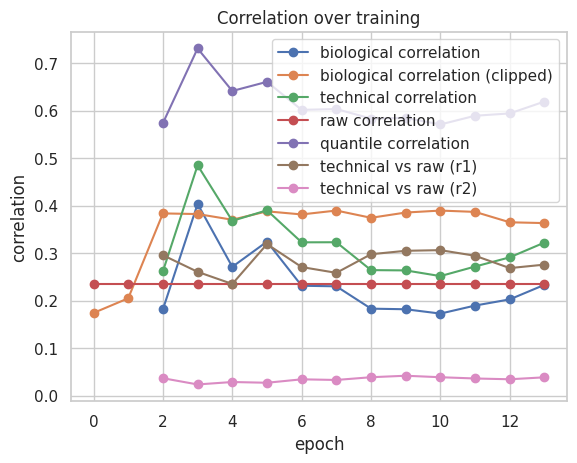

In [5]:
h3k27me3_all_3_full_small = run_analysis(Path("/lotterlab/users/abdul/repos/chipvi/runs/gpu/h3k27me3/run_all_3_nb_scaled_full_ds_small_network"))
h3k27me3_all_3_full_small[-1]

--------------------------------------------------
1.8426, 1.2338
--------------------------------------------------
2.0025, 1.7756
--------------------------------------------------
2.4759, 3.1302
--------------------------------------------------
2.6514, 1.7992
--------------------------------------------------
2.7109, 1.8602
--------------------------------------------------
3.2864, 1.5797
--------------------------------------------------
5.8618, 1.6187


/tmp/ipykernel_802610/48461319.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1[0].set_xticklabels(ax1[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_802610/48461319.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1[1].set_xticklabels(ax1[1].get_xticklabels(), rotation=45)


Text(0.5, 1.0, 'Quantile')

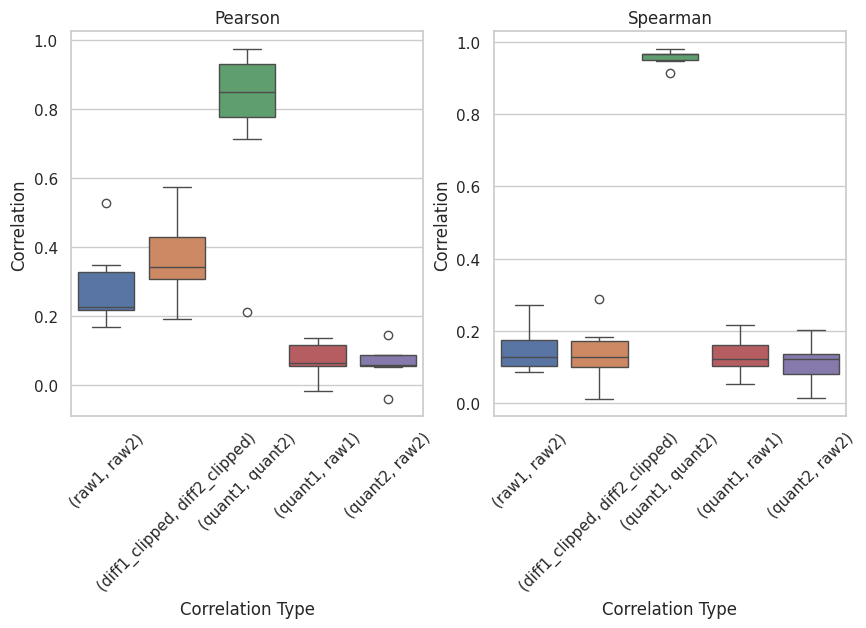

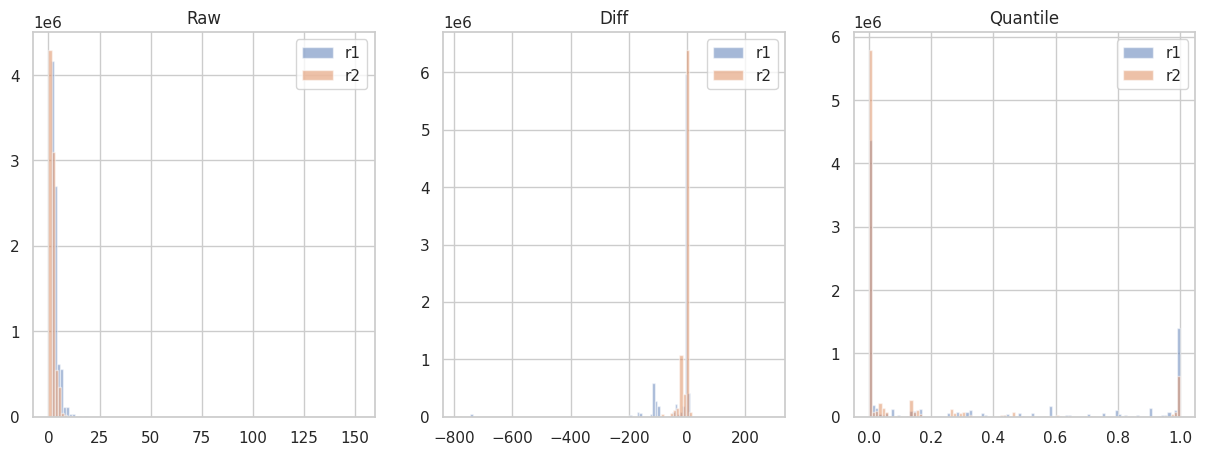

In [9]:
corrs_pearson = {
    "(raw1, raw2)": [],
    # "diff": [],
    "(diff1_clipped, diff2_clipped)": [],
    "(quant1, quant2)": [],
    "(quant1, raw1)": [],
    "(quant2, raw2)": [],
    # "tech_raw_r1": [],
    # "tech_raw_r2": [],
}
corrs_spearman = {
    "(raw1, raw2)": [],
    # "diff": [],
    "(diff1_clipped, diff2_clipped)": [],
    "(quant1, quant2)": [],
    "(quant1, raw1)": [],
    "(quant2, raw2)": [],
    # "tech_raw_r1": [],
    # "tech_raw_r2": [],
}
for r1_sd, r1_sd_df in h3k27me3_all_3_full_small[-1].groupby("exp_sd_r1"):
    r2_sds = r1_sd_df["exp_sd_r2"].unique()
    if len(r2_sds) > 1:
        raise ValueError
    r2_sd = r2_sds[0]
    print("-" * 50)
    print(f"{r1_sd:.4f}, {r2_sd:.4f}")
    raw_corr = np.corrcoef(r1_sd_df['yi_r1'], r1_sd_df['yi_r2'])[0][1]
    raw_corr_spearman = stats.spearmanr(r1_sd_df['yi_r1'], r1_sd_df['yi_r2'])[0]
    diff_corr = np.corrcoef(r1_sd_df['mu1_r1_diff'], r1_sd_df['mu2_r2_diff'])[0][1]
    diff_corr_spearman = stats.spearmanr(r1_sd_df['mu1_r1_diff'], r1_sd_df['mu2_r2_diff'])[0]
    diff_corr_clipped = np.corrcoef(r1_sd_df['mu1_r1_diff'].clip(lower=0), r1_sd_df['mu2_r2_diff'].clip(lower=0))[0][1]
    diff_corr_clipped_spearman = stats.spearmanr(r1_sd_df['mu1_r1_diff'].clip(lower=0), r1_sd_df['mu2_r2_diff'].clip(lower=0))[0]
    quantile_corr = np.corrcoef(r1_sd_df['quantile_r1'], r1_sd_df['quantile_r2'])[0][1]
    quantile_corr_spearman = stats.spearmanr(r1_sd_df['quantile_r1'], r1_sd_df['quantile_r2'])[0]
    tech_raw_r1_corr = np.corrcoef(r1_sd_df['mu_tech_r1'], r1_sd_df['yi_r1'])[0][1]
    tech_raw_r1_corr_spearman = stats.spearmanr(r1_sd_df['mu_tech_r1'], r1_sd_df['yi_r1'])[0]
    tech_raw_r2_corr = np.corrcoef(r1_sd_df['mu_tech_r2'], r1_sd_df['yi_r2'])[0][1]
    tech_raw_r2_corr_spearman = stats.spearmanr(r1_sd_df['mu_tech_r2'], r1_sd_df['yi_r2'])[0]
    q1_r1_corr = np.corrcoef(r1_sd_df['quantile_r1'], r1_sd_df['yi_r1'])[0][1]
    q1_r1_corr_spearman = stats.spearmanr(r1_sd_df['quantile_r1'], r1_sd_df['yi_r1'])[0]
    q2_r2_corr = np.corrcoef(r1_sd_df['quantile_r2'], r1_sd_df['yi_r2'])[0][1]
    q2_r2_corr_spearman = stats.spearmanr(r1_sd_df['quantile_r2'], r1_sd_df['yi_r2'])[0]
    corrs_pearson["(raw1, raw2)"].append(raw_corr)
    corrs_spearman["(raw1, raw2)"].append(raw_corr_spearman)
    # corrs["diff"].append(diff_corr)
    corrs_spearman["(diff1_clipped, diff2_clipped)"].append(diff_corr_clipped_spearman)
    corrs_pearson["(diff1_clipped, diff2_clipped)"].append(diff_corr_clipped)
    corrs_pearson["(quant1, quant2)"].append(quantile_corr)
    corrs_spearman["(quant1, quant2)"].append(quantile_corr_spearman)
    corrs_pearson["(quant1, raw1)"].append(q1_r1_corr)
    corrs_spearman["(quant1, raw1)"].append(q1_r1_corr_spearman)
    corrs_pearson["(quant2, raw2)"].append(q2_r2_corr)
    corrs_spearman["(quant2, raw2)"].append(q2_r2_corr_spearman)
    # corrs["tech_raw_r1"].append(tech_raw_r1_corr)
    # corrs["tech_raw_r2"].append(tech_raw_r2_corr)
    

    # print(f"Raw corr: {np.corrcoef(r1_sd_df['yi_r1'], r1_sd_df['yi_r2'])[0][1]}")
    # print(f"Diff corr (unclipped): {np.corrcoef(r1_sd_df['mu1_r1_diff'], r1_sd_df['mu2_r2_diff'])[0][1]}")
    # print(f"Diff corr (clipped): {np.corrcoef(r1_sd_df['mu1_r1_diff'].clip(lower=0), r1_sd_df['mu2_r2_diff'].clip(lower=0))[0][1]}")
    # print(f"Quantile corr: {np.corrcoef(r1_sd_df['quantile_r1'], r1_sd_df['quantile_r2'])[0][1]}")

corr_df_pearson = pd.DataFrame(corrs_pearson)
corr_df_spearman = pd.DataFrame(corrs_spearman)
fig1, ax1 = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(data=corr_df_pearson, ax=ax1[0])
sns.boxplot(data=corr_df_spearman, ax=ax1[1])
ax1[0].set_title("Pearson")
ax1[1].set_title("Spearman")
ax1[0].set_xlabel("Correlation Type")
ax1[0].set_ylabel("Correlation")
ax1[1].set_xlabel("Correlation Type")
ax1[1].set_ylabel("Correlation")
ax1[0].set_xticklabels(ax1[0].get_xticklabels(), rotation=45)
ax1[1].set_xticklabels(ax1[1].get_xticklabels(), rotation=45)

fig2, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(h3k27me3_all_3_full_small[-1]['yi_r1'], bins=100, alpha=0.5, label="r1")
axes[0].hist(h3k27me3_all_3_full_small[-1]['yi_r2'], bins=100, alpha=0.5, label="r2")
axes[0].legend()
axes[0].set_title("Raw")
axes[1].hist(h3k27me3_all_3_full_small[-1]['mu1_r1_diff'], bins=100, alpha=0.5, label="r1")
axes[1].hist(h3k27me3_all_3_full_small[-1]['mu2_r2_diff'], bins=100, alpha=0.5, label="r2")
axes[1].legend()
axes[1].set_title("Diff")
axes[2].hist(h3k27me3_all_3_full_small[-1]['quantile_r1'], bins=100, alpha=0.5, label="r1")
axes[2].hist(h3k27me3_all_3_full_small[-1]['quantile_r2'], bins=100, alpha=0.5, label="r2")
axes[2].legend()
axes[2].set_title("Quantile")

  1%|          | 1/100 [00:11<18:33, 11.24s/it]

Loaded epoch 0


  2%|▏         | 2/100 [00:22<18:25, 11.28s/it]

Loaded epoch 1


  3%|▎         | 3/100 [00:33<18:20, 11.35s/it]

Loaded epoch 2


  4%|▍         | 4/100 [00:44<17:56, 11.21s/it]

Loaded epoch 3


  5%|▌         | 5/100 [00:55<17:31, 11.06s/it]

Loaded epoch 4


  6%|▌         | 6/100 [01:07<17:25, 11.12s/it]

Loaded epoch 5


  7%|▋         | 7/100 [01:18<17:10, 11.08s/it]

Loaded epoch 6


  8%|▊         | 8/100 [01:28<16:55, 11.04s/it]

Loaded epoch 7


  9%|▉         | 9/100 [01:39<16:43, 11.03s/it]

Loaded epoch 8


 10%|█         | 10/100 [01:51<16:37, 11.08s/it]

Loaded epoch 9


 11%|█         | 11/100 [02:02<16:27, 11.10s/it]

Loaded epoch 10


,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2,r_r1,r_r2,ctrl_reads_r1,ctrl_mapq_r1,ctrl_sd_r1,exp_mapq_r1,exp_sd_r1,ctrl_reads_r2,ctrl_mapq_r2,ctrl_sd_r2,exp_mapq_r2,exp_sd_r2,quantile_r1,quantile_r2
0,3.563451,3.410883,-1.563451,-8.376123,2.0,0.0,2.646074,3.007129,1.0,0.999000,2.493534,0.999000,2.608079,0.0,1.000000,2.898569,1.000000,2.455705,0.868357,0.314882
1,3.563451,3.410883,-1.563451,-8.376123,2.0,0.0,2.646074,3.007129,1.0,0.999000,2.493534,0.999000,2.608079,0.0,1.000000,2.898569,1.000000,2.455705,0.868357,0.314882
2,3.636684,3.410883,-1.636684,-8.376123,2.0,0.0,2.856233,3.007129,0.0,1.000000,2.493534,0.999000,2.608079,0.0,1.000000,2.898569,1.000000,2.455705,0.842456,0.314882
3,3.636684,3.410883,-1.636684,-8.376123,2.0,0.0,2.856233,3.007129,0.0,1.000000,2.493534,0.999000,2.608079,0.0,1.000000,2.898569,1.000000,2.455705,0.842456,0.314882
4,3.563451,3.410883,-2.563451,-8.376123,1.0,0.0,2.646074,3.007129,1.0,0.999000,2.493534,0.999000,2.608079,0.0,1.000000,2.898569,1.000000,2.455705,0.699993,0.314882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8781307,3.855972,1.658789,-1.855972,0.612124,2.0,2.0,2.754966,2.051226,1.0,0.999937,2.758586,0.999937,2.629396,4.0,0.999937,2.591536,0.999937,1.793976,0.864800,0.862377
8781308,3.782594,1.681266,-1.782594,-1.222176,2.0,1.0,2.551929,2.362555,2.0,0.999937,2.758586,0.999937,2.629396,2.0,0.999937,2.591536,0.999937,1.793976,0.887993,0.631028
8781309,3.782594,1.681250,-1.782594,-3.016122,2.0,0.0,2.551929,2.362562,2.0,0.999937,2.758586,0.999937,2.629396,2.0,0.999937,2.591536,1.000000,1.793976,0.887993,0.337217
8781310,3.719139,1.666939,-0.719139,-1.196473,3.0,1.0,2.368046,2.199098,3.0,0.999937,2.758586,0.999937,2.629396,3.0,0.999937,2.591536,0.999937,1.793976,0.966086,0.667644


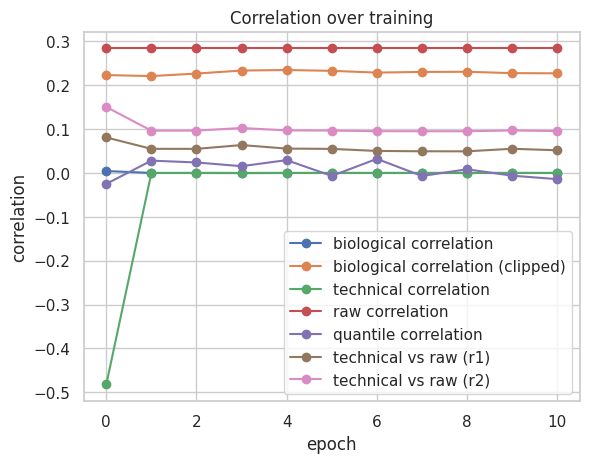

In [7]:
ctcf_all_3_full_small = run_analysis(Path("/lotterlab/users/abdul/repos/chipvi/runs/gpu/ctcf/run_all_3_nb_scaled_full_ds_small_network"))
ctcf_all_3_full_small[-1]

--------------------------------------------------
1.2000, 5.5967
--------------------------------------------------
1.7558, 1.4023
--------------------------------------------------
2.5138, 2.6151
--------------------------------------------------
2.5241, 2.7885
--------------------------------------------------
2.5922, 2.7807
--------------------------------------------------
2.6081, 2.4557
--------------------------------------------------
2.6294, 1.7940
--------------------------------------------------
3.2092, 1.8924


/tmp/ipykernel_794734/3660925773.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


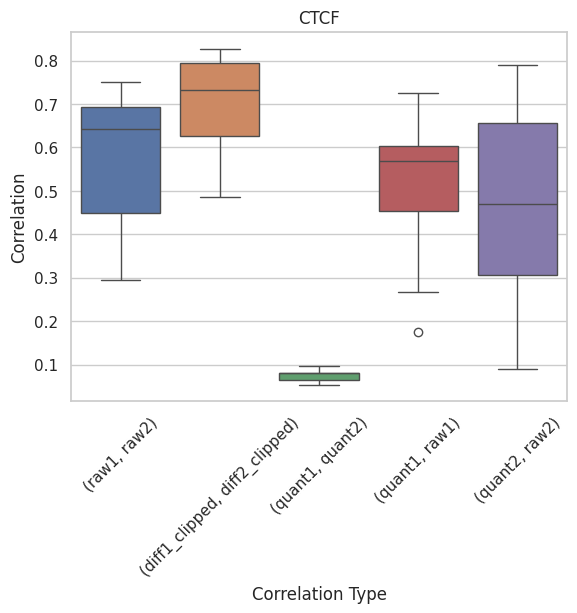

In [8]:
corrs = {
    "(raw1, raw2)": [],
    # "diff": [],
    "(diff1_clipped, diff2_clipped)": [],
    "(quant1, quant2)": [],
    "(quant1, raw1)": [],
    "(quant2, raw2)": [],
    # "tech_raw_r1": [],
    # "tech_raw_r2": [],
}
for r1_sd, r1_sd_df in ctcf_all_3_full_small[-1].groupby("exp_sd_r1"):
    r2_sds = r1_sd_df["exp_sd_r2"].unique()
    if len(r2_sds) > 1:
        raise ValueError
    r2_sd = r2_sds[0]
    print("-" * 50)
    print(f"{r1_sd:.4f}, {r2_sd:.4f}")
    raw_corr = np.corrcoef(r1_sd_df['yi_r1'], r1_sd_df['yi_r2'])[0][1]
    diff_corr = np.corrcoef(r1_sd_df['mu1_r1_diff'], r1_sd_df['mu2_r2_diff'])[0][1]
    diff_corr_clipped = np.corrcoef(r1_sd_df['mu1_r1_diff'].clip(lower=0), r1_sd_df['mu2_r2_diff'].clip(lower=0))[0][1]
    quantile_corr = np.corrcoef(r1_sd_df['quantile_r1'], r1_sd_df['quantile_r2'])[0][1]
    tech_raw_r1_corr = np.corrcoef(r1_sd_df['mu_tech_r1'], r1_sd_df['yi_r1'])[0][1]
    tech_raw_r2_corr = np.corrcoef(r1_sd_df['mu_tech_r2'], r1_sd_df['yi_r2'])[0][1]
    q1_r1_corr = np.corrcoef(r1_sd_df['quantile_r1'], r1_sd_df['yi_r1'])[0][1]
    q2_r2_corr = np.corrcoef(r1_sd_df['quantile_r2'], r1_sd_df['yi_r2'])[0][1]
    corrs["(raw1, raw2)"].append(raw_corr)
    # corrs["diff"].append(diff_corr)
    corrs["(diff1_clipped, diff2_clipped)"].append(diff_corr_clipped)
    corrs["(quant1, quant2)"].append(quantile_corr)
    corrs["(quant1, raw1)"].append(q1_r1_corr)
    corrs["(quant2, raw2)"].append(q2_r2_corr)
    # corrs["tech_raw_r1"].append(tech_raw_r1_corr)
    # corrs["tech_raw_r2"].append(tech_raw_r2_corr)
    

    # print(f"Raw corr: {np.corrcoef(r1_sd_df['yi_r1'], r1_sd_df['yi_r2'])[0][1]}")
    # print(f"Diff corr (unclipped): {np.corrcoef(r1_sd_df['mu1_r1_diff'], r1_sd_df['mu2_r2_diff'])[0][1]}")
    # print(f"Diff corr (clipped): {np.corrcoef(r1_sd_df['mu1_r1_diff'].clip(lower=0), r1_sd_df['mu2_r2_diff'].clip(lower=0))[0][1]}")
    # print(f"Quantile corr: {np.corrcoef(r1_sd_df['quantile_r1'], r1_sd_df['quantile_r2'])[0][1]}")

corr_df = pd.DataFrame(corrs)
fig, ax = plt.subplots()
sns.boxplot(data=corr_df, ax=ax)
ax.set_title("CTCF")
ax.set_xlabel("Correlation Type")
ax.set_ylabel("Correlation")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()